# Projet final  ( lgp @work )

### Acquisition et chargement des données

* Récupération des fichiers Excel avec les classements
* Mise en place d'une copie locale des fichiers Excel afin de ne pas les recharger à chaque run.
* Vers la fin de la course le format des fichiers Excel change avec les arrivées des voiliers : il est possible de s'arrêter juste avant.
* Extraction des caractéristiques techniques de chacun des voiliers.




In [1]:
# Chargement des libs
import pandas as pd
import os
import sys
from bs4 import BeautifulSoup as bs
import requests
import datetime as dt
import dateparser
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


# libs for xlsx "xxid" fix
import tempfile
from zipfile import ZipFile
import shutil
from fnmatch import fnmatch
import re
import glob
#

# variables utiliséees globalement
URL_RESULTS="https://www.vendeeglobe.org/fr/classement"
FILE_RESULTS="classement.html"
URL_GLOSSAIRE="https://www.vendeeglobe.org/fr/glossaire"
FILE_GLOSSAIRE="glossaire.html"
EXCELS_DIR="results"
PICKLE_DF="pickle_classement.pkl"
PICKLE_DF_TECH="pickle_classement_et_tech.pkl"


* Récupération des fichiers Excel avec les classements
* Mise en place d'une copie locale des fichiers Excel afin de ne pas les recharger à chaque run.
* Chargement dans un dataframe (clean up et split des noms de colonne, préparation des data pour traitements)

In [2]:
def get_soup_from_url(url):
    """
    Retourne la soupe de l'url du fichier html passé en paramètre
    """
    res = requests.get(url)
    soup = bs(res.content, 'html.parser')
    return soup

def get_soup_from_file(file):
    """
    Retourne la soupe du fichier html passé en paramètre
    """
    soup = bs(file, 'html.parser')
    return soup

def parse_url_for_excels(url):
    """
    Récupère la liste des fichiers excel et les télécharge dans le répertoire "results/" (EXCELS_DIR)
    """
    print("Getting url of files to download...")
    soup = get_soup_from_url(url)
    dates_list = []
    for option in soup.find_all('option'):
        if option['value'] != '':
            dates_list.append(option['value'])
    
    # format de fichiers à récupérer 
    # https://www.vendeeglobe.org/download-race-data/vendeeglobe_20210305_080000.xlsx
    print("Downloading xlsx files...")
    for date in dates_list:
        xlsx_name = f'vendeeglobe_{date}.xlsx'
        xlsx_file = requests.get(f"https://www.vendeeglobe.org//download-race-data/{xlsx_name}")
        open(os.path.join(EXCELS_DIR, xlsx_name), 'wb').write(xlsx_file.content)

def fix_xlsx_errors():
    """
    Fix des fichiers xlsx, un header xxid dans un des fichiers du xlsx n'est pas reconnu par openpyxl
    """
    print("Fixing xlsx files...")
    for file in [f for f in glob.glob(EXCELS_DIR + "/*.xlsx")]:
        change_in_zip(file, name_filter='xl/styles.xml', # the problematic property is found in the style xml files
                      change=lambda d: re.sub(b'xxid="\d*"', b"", d))
        
# fix of xlsx files
def change_in_zip(file_name, name_filter, change):
    """
    le fix appliqué à chaque fichier
    """
    tempdir = tempfile.mkdtemp()
    try:
        tempname = os.path.join(tempdir, 'new.zip')
        with ZipFile(file_name, 'r') as r, ZipFile(tempname, 'w') as w:
            for item in r.infolist():
                data = r.read(item.filename)          
                data = change(data)
                w.writestr(item, data)
        shutil.move(tempname, file_name)
    finally:
        shutil.rmtree(tempdir)


def get_excel_files():
    if not os.path.isdir(EXCELS_DIR):
        os.mkdir('results')
        print("Files being downloaded to ", EXCELS_DIR)
        parse_url_for_excels(URL_RESULTS)
        fix_xlsx_errors()
    else:
        print(f"Les fichiers sont déjà dans le répertoire \"{EXCELS_DIR}/\" et déjà traités, aucun nouveau fichier téléchargé ni traité.")


**L'appel à la commande *get_excel_files.xlsx* ne fait rien si le répertoire *results/* existe. Il est crée lors du 1er téléchargement** 

In [3]:
get_excel_files()

Les fichiers sont déjà dans le répertoire "results/" et déjà traités, aucun nouveau fichier téléchargé ni traité.


In [4]:
%%time
def create_dataframe_from_files(path, verbose=True):
    """
    Sélection des fichiers et concatenate dans une dataframe
    
    Returns a dataframe
    """
    if not verbose:
        print("Quiet mode activated. Be patient...", end='')
    dfs=[]
    for filename in [f for f in glob.glob(path + "/*.xlsx")]:
        # on exclu les fichiers donnant des infos sur les concurrents arrivées (à partir du 27 janvier)
        # on exclu le 1er fichier au départ qui est sans données
        if filename >= path+'/vendeeglobe_20210127_170000.xlsx' or filename == path+"/vendeeglobe_20201108_120200.xlsx":
            continue
        if verbose:
            print('Including file ', filename)

        # read excel
        x = pd.read_excel(filename, 
                          dtype=object,
                          skiprows=[1, 2, 3], 
                          header=1, 
                          usecols=range(1,21), 
                          skipfooter=4)
        # do not use col 0
        # remove footer
        # rename 1  Classement
        # split 2 on \n rename Pays /  Voile
        # split 3 on \n ren Skipper /  Bateau
        # change names

        # ajout colonne avec le timestamp du fichier d'où est extrait la data
        x['Fichier de resultats'] = filename[-20:-5]

        dfs.append(x)
    
    df = pd.concat(dfs , ignore_index=True)
    #df.duplicated().value_counts()

    if not verbose:
        print("done")
    return df

def clean_data(df, verbose=True):
    """
    Cleanup des noms de colonnes
    """
    print('Cleaning dataframe... ', end='')

    # cleanup sur nom dde cols, etc.
    df.rename(inplace=True, columns={'Unnamed: 1': 'Classement', 'Unnamed: 2': 'Pays', 'Unnamed: 3': 'Skipper', 
                                    'Unnamed: 19': 'DTF', 'Unnamed: 20': 'DTL', "Heure FR\nHour FR": "Heure FR"})
    df[['Pays','Voile']] = df["Pays"].str.extract("(.*)\n(.*)").astype(str)
    df[['Skipper','Bateau']] = df["Skipper"].str.extract("(.*)\n(.*)").astype(str)
    df[['Heure FR']] = df["Heure FR"].str.extract("(.*)\n.*").astype(str)
    df.rename(inplace=True, columns={'Latitude\nLatitude': 'Latitude', 
                    'Longitude\nLongitude': 'Longitude', 
                    'Cap\nHeading': 'Cap 30m', 'Vitesse\nSpeed': 'Vitesse 30m', 
                    'VMG\nVMG': 'VMG 30m', 'Distance\nDistance': 'Distance 30m',
                    'Cap\nHeading.1': 'Cap dernier', 'Vitesse\nSpeed.1': 'Vitesse dernier', 
                    'VMG\nVMG.1': 'VMG dernier', 'Distance\nDistance.1': 'Distance dernier',
                    'Cap\nHeading.2': 'Cap 24h', 'Vitesse\nSpeed.2': 'Vitesse 24h', 
                    'VMG\nVMG.2': 'VMG 24h', 'Distance\nDistance.2': 'Distance 24h'})

    for col in ['Vitesse 30m','VMG 30m', 'Vitesse dernier', 'VMG dernier', 'Vitesse 24h', 'VMG 24h']:
        df[[col]] = df[col].str.extract("(.*) kts").astype(float)
    for col in ['Distance 30m', 'Distance dernier', 'Distance 24h', 'DTF', 'DTL']:
        df[[col]] = df[col].str.extract("(.*) nm").astype(float)
    for col in ['Cap 30m', 'Cap dernier', 'Cap 24h']:
        df[[col]] = df[col].str.extract("(\d*)°").astype(float)

    # classement des abandons trasnformé en int
    df[['Classement']] = df[['Classement']].applymap(lambda x: x.replace('RET', '34')).astype(str)
    df[['Classement']] = df[['Classement']].applymap(lambda x: x.replace('NL', '35')).astype(str)
    
    
    # suppression des lignes avec Nan
    # ce sont les abandons
    df = df.dropna()

    print("done")
    return df


# backup dans un fichier pickle pour ne pas retraiter à chaque run
if not os.path.isfile(PICKLE_DF):
    print(f"\nLoading data from {EXCELS_DIR}/*.xlsx files")
    df = create_dataframe_from_files(EXCELS_DIR, verbose=False)
    df = clean_data(df)
    df.to_pickle(PICKLE_DF)
    print(f"{PICKLE_DF} saved")
else:
    print(f"\nLoading data from pickle file {PICKLE_DF}...", end='')
    df = pd.read_pickle(PICKLE_DF)
    print(' done')
    print(f'\n(Note: if you need to reset pickle content remove file {PICKLE_DF} manually)')
    
df.shape



Loading data from results/*.xlsx files
Quiet mode activated. Be patient...done
Cleaning dataframe... done
pickle_classement.pkl saved
CPU times: user 24.1 s, sys: 63.6 ms, total: 24.2 s
Wall time: 24.2 s


(13703, 23)

In [5]:
df.iloc[10000]

Classement                                     29
Pays                                             
Skipper                            Clément Giraud
Heure FR                                 12:30 FR
Latitude                               38°56.43'N
Longitude                              19°07.68'W
Cap 30m                                     228.0
Vitesse 30m                                   4.2
VMG 30m                                       3.3
Distance 30m                                  2.1
Cap dernier                                 177.0
Vitesse dernier                               3.8
VMG dernier                                   3.7
Distance dernier                             11.4
Cap 24h                                     241.0
Vitesse 24h                                   8.2
VMG 24h                                       5.7
Distance 24h                                196.7
DTF                                       23557.6
DTL                                         370.4




#### Extraction des caractéristiques techniques de chacun des voiliers.

* Extraction des caractéristiques techniques de chacun des voiliers depuis la page glossaire 
* ajout des informations sur la présence de foils depuis la page classement



Traitement manuel de la page web https://www.vendeeglobe.org/fr/classement pour récupérer l'info sur les foils et le classement final

In [6]:
def get_infos_from_classement(df):
    """
    Récupère les infos skipper, foil, etc.
    
    Retourne une liste de liste de [classement final, nom skipper, Oui/Non (foil)]
    """
    print("Getting boats infos...")
    classement_html=""
    if not os.path.isfile(FILE_RESULTS):
        print("Reading file from far away")
        req = requests.get(URL_RESULTS)
        classement_html = req.content
        open(os.path.join(FILE_RESULTS), 'wb').write(classement_html)
    else:
        print("Reading file locally")
        with open(FILE_RESULTS,'r') as file:
            classement_html = file.read()

    soup = get_soup_from_file(classement_html)
    skippers_info=[]
    for ranking_row in soup.find_all("tr", {"class": "ranking-row"}):
        cell_rank = ranking_row.find('td', attrs={'class': 'row-number'} ).text
        cell_skipper = ranking_row.find('td', attrs={'class': 'row-skipper'} ).contents[2]
        cell_skipper = re.search(r'\n\s+(\w[\s\'\w-]*)', cell_skipper).group(1).title()
        cell_has_foil = ranking_row.find('td', attrs={'class': 'row-layout'} ).text
        skippers_info.append([cell_rank, cell_skipper, cell_has_foil])
    return skippers_info

# Extraction des caractéristiques techniques de chacun des voiliers.
def get_infos_from_glossaire():
    """
    Récupère les infos skipper, foil, etc.
    """
    if not os.path.isfile(FILE_GLOSSAIRE):
        print("Reading file from far away..." , end='')
        req = requests.get(URL_GLOSSAIRE)
        glossaire_html = req.content
        open(os.path.join(FILE_GLOSSAIRE), 'wb').write(glossaire_html.content)
    else:
        print("Reading file locally... " , end='')
        with open(FILE_GLOSSAIRE,'r') as file:
            glossaire_html = file.read()

    soup = get_soup_from_file(glossaire_html)
    
    tech_info={}
    
    boats_popup_infos = soup.find_all('div', attrs={'class': 'boats-list__popup-infos'})
    specs_list = soup.find_all('ul', attrs={'class': 'boats-list__popup-specs-list'})
#     print(len(boats_popup_infos), len(specs_list))
#     v = []
    for i in range(len(boats_popup_infos)):
        bateau = boats_popup_infos[i].h3.text
        specs = specs_list[i]
        voile = specs.find(string=re.compile("Numéro de voile : "))
        if voile == None:
            voile = 0
        else:
            voile = re.match(".*: ([\w\s]+)", voile)[1]
        anc_name = specs.find(string=re.compile("Anciens noms du bateau : "))
        if anc_name==None:
            anc_name = bateau
        else:    
            anc_name = re.match(".*: ([,\w\s]+)", anc_name)[1]
        Architecte = specs.find(string=re.compile("Architecte")) # : Marc Lombard</li>
        Architecte = re.match(".*: ([\s\w]+)", Architecte)[1]
        Chantier= specs.find(string=re.compile("Chantier")) #MAG France</li>
        Chantier= re.match(".*: ([\s\w]+)", Chantier)[1]
        lancement= specs.find(string=re.compile("Date de lancement")) # : 01 Mars 1998</li>
        lancement= re.match(".*: ([\s\w]+)", lancement)[1]
        Longueur= specs.find(string=re.compile("Longueur")) # : 18,28m</li>
        Longueur= re.match(".*: ([,.\d]+)", Longueur)[1]
        Largeur = specs.find(string=re.compile("Largeur")) # : 5,54m</li>
        Largeur = re.match(".*: ([,\d]+)", Largeur)[1]
        Tirant = specs.find(string=re.compile("Tirant d'eau")) # : 4,50m</li>
        Tirant = re.match(".*: ([,\d]+)", Tirant)[1]
        poids = specs.find(string=re.compile("Déplacement")) # : 9t</li>
        poids = re.match(".*: ([,\dncNC]+)\s?t?", poids)[1]
        if poids=="nc" or poids=="NC":
            poids="0"
        derives = specs.find(string=re.compile("Nombre de dérives")) # : 2</li>
        derives = re.match(".*: (.*)", derives)[1]
        mat = specs.find(string=re.compile("Hauteur mât")) # : 29 m</li>
        mat = re.match(".*: ([,\d]+)", mat)[1]
        quille = specs.find(string=re.compile("Voile quille")) # : acier</li>
        if quille == None:
            quille = "NC"
        else:
            quille = re.match(".*: ([\s\w]+)", quille)[1].lower() 
        Surface_pres = specs.find(string=re.compile("Surface de voiles au près")) # : 260 m2</li>
        Surface_pres = re.match(".*: ([,\d]+).*m[2²]", Surface_pres)[1]
        Surface_portant = specs.find(string=re.compile("Surface de voiles au portant")) # : 580 m2</li>
        Surface_portant = re.match(".*: ([,\d]+).*m[2²]", Surface_portant)[1]

        # manual cleanup des numéros de voiles qui ne matchent pas avec les fichiers classements
        if bateau == 'LinkedOut':
            voile = "FRA 59"
        if voile == "001":
            voile = "FRA 01"
        if voile == "4":
            voile = "FRA 4" 
        if voile == "2":
            voile = "FRA 02"
#         if voile == "6":
#                 voile = "FRA 6"
        if voile == "08":
            voile = "FRA 8"
        if voile == "16":
            voile = "MON 10"
        if voile == "17":
            voile = "FRA 17"
        if voile == "18":
            voile = "FRA 18"
        if voile == "69":
            voile = "FRA 69"
        if voile == "SUI07":
            voile = "SUI 7"
        if voile == "GBR77":
            voile = "GBR 777"
        if voile[3] != " ":
#             print(voile)
            voile = voile[0:3]+" "+voile[3:]
#             print(voile)
        tech_info[voile] = {'Voile': voile, 'Nom bateau': bateau, 'Longeur': Longueur, 
                            'Largeur': Largeur, 'Tirant': Tirant, 
                           'Poids': poids, "Dérives": derives,
                           'Hauteur mât': mat, "Quille": quille, 
                            "Surface près": Surface_pres,  "Surface portant": Surface_portant,
                           "Année lancement": lancement[-4:], 'Ancien nom': anc_name}
#         v.append(voile)
    print("Done")
    return tech_info



In [7]:

foils_etc = get_infos_from_classement(df)

# manual fixes
# skippers with names not matching
# from web page 2 errors
skips=set()
for f in foils_etc:
    skipper=f[1]
    skips.add(skipper)
all_skips = set(df['Skipper'])
# print(skips.difference(set(all_skips)))
df[['Skipper']] = df[['Skipper']].applymap(lambda x: x.replace('Arnaud Boissieres', 'Arnaud Boissières')).astype(str)

for f in foils_etc:
    if f[1]=="Sam Davies":
        skipper = "Samantha Davies"
    elif f[1]=="Alan  Roura":
        skipper="Alan Roura"
    else:
        skipper=f[1]
    foil=f[2]
    
    df.loc[df['Skipper']==skipper, 'Foil'] = foil
    df.loc[df['Skipper']==skipper, 'Classement final'] = f[0]

df[['Classement final']] = df[['Classement final']].applymap(lambda x: x.replace('ABD', '34')).astype(str)
df[['Classement final']] = df[['Classement final']].astype(int)
df[['Classement']] = df[['Classement']].astype(int)


# set(df['Skipper'])
df[['Foil']] = df[['Foil']].applymap(lambda x: x.replace('Oui', '1')).astype(str)
df[['Foil']] = df[['Foil']].applymap(lambda x: x.replace('Non', '0')).astype(str)
df[['Foil']] = df[['Foil']].astype(int)
# df[['Foil']] = df[['Foil']].astype(bool)



Getting boats infos...
Reading file locally


In [8]:
#################################################################################
# MERGE DES CLASSEMENTS ET DONNEES TECHNIQUES


# tech_info contains a dict of technical details
# backup dans un fichier pickle pour ne pas retraiter à chaque run
# https://pandas.pydata.org/pandas-docs/stable/user_guide/merging.html#brief-primer-on-merge-methods-relational-algebra


mapping_quilles={}
mapping_derives={}
mapping_inv_quilles={}
mapping_inv_derives={}
def last_cleanup(df):
    ## cleanup columns types, changing categorical values to numbers, renaming and ordering

    df['Tirant'] = df["Tirant"].str.replace(',','.').astype(float)
    df['Longeur'] = df["Longeur"].str.replace(',','.').astype(float)
    df['Largeur'] = df["Largeur"].str.replace(',','.').astype(float)
    df['Poids'] = df["Poids"].str.replace(',','.').astype(float)
    df["Hauteur mât"] = df["Hauteur mât"].str.replace(',','.').astype(float)
    df["Surface près"] = df["Surface près"].str.replace(',','.').astype(float)
    df["Surface portant"] = df["Surface portant"].str.replace(',','.').astype(float)
    df["Année lancement"] = df["Année lancement"].astype(int)


    for i, name in enumerate(sorted(df['Quille'].unique())):
        mapping_quilles[i]=name
        mapping_inv_quilles[name]=i
    for i, name in enumerate(sorted(df['Dérives'].unique())):
        mapping_derives[i]=name
        mapping_inv_derives[name]=i

    mapping_derives, mapping_quilles
    # traitement du gender
    df['Dérives'] = df['Dérives'].map(mapping_inv_derives)
    df['Quille']  = df['Quille'].map(mapping_inv_quilles)
    df['Dérives'] = df['Dérives'].astype(int)
    df['Quille']  = df['Quille'].astype(int)

    columns=['Classement', 'Classement final', 'Skipper', 'Bateau', 'Voile', 'Pays', 'Heure FR', 'Latitude', 'Longitude',
           'Cap 30m', 'Vitesse 30m', 'VMG 30m', 'Distance 30m', 'Cap dernier',
           'Vitesse dernier', 'VMG dernier', 'Distance dernier', 'Cap 24h',
           'Vitesse 24h', 'VMG 24h', 'Distance 24h', 'DTF', 'DTL',
           'Fichier de resultats', 'Foil', 'Dérives', 'Tirant', 'Longeur', 'Largeur', 'Poids', 
           'Hauteur mât', 'Quille', 'Surface près', 'Surface portant',
           'Année lancement', 'Ancien nom']

    df = df[columns]
    return(df)

def merge(df):
    if not os.path.isfile(PICKLE_DF_TECH):  
        print(f"\nLoading boats technical data")
        tech_info = get_infos_from_glossaire()

        print(f"\nMerging df with technical data")
        df_tech_info = pd.DataFrame(tech_info).T        
        df_merge = pd.merge(df, df_tech_info, on="Voile")
        df_merge = last_cleanup(df_merge)

        df_merge.to_pickle(PICKLE_DF_TECH)
        print(f"Pickle file {PICKLE_DF_TECH} saved.")
    else:
        print(f"\nLoading data from pickle file {PICKLE_DF_TECH}...", end='')
        df_merge = pd.read_pickle(PICKLE_DF_TECH)
        print(' done')
        print(f'\n(Note: if you need to renew pickle content remove file {PICKLE_DF_TECH} manually)')
    return df_merge

df = merge(df)



Loading boats technical data
Reading file locally... Done

Merging df with technical data
Pickle file pickle_classement_et_tech.pkl saved.


In [9]:
# check for Nan values
# df.loc[df.isna().any(axis=1)]

df['Dérives'].unique()
sorted(df['Quille'].unique())
df.loc[df['Dérives']=='foiler']
df.iloc[2546]

df.iloc[10000]
# df.info()

Classement                                  18
Classement final                            11
Skipper                           Armel Tripon
Bateau                  L'Occitane en Provence
Voile                                   FRA 02
Pays                                        FR
Heure FR                              15:00 FR
Latitude                            46°18.29'N
Longitude                           08°58.37'W
Cap 30m                                  194.0
Vitesse 30m                                9.8
VMG 30m                                    9.7
Distance 30m                               4.9
Cap dernier                              195.0
Vitesse dernier                           10.9
VMG dernier                               10.9
Distance dernier                          32.8
Cap 24h                                  266.0
Vitesse 24h                               12.4
VMG 24h                                    7.1
Distance 24h                             298.4
DTF          



La position 34 représente un abandon

Les quilles et dérives en fonction des matériaux sont regroupés comme ceci

In [10]:
mapping_derives, mapping_quilles

({0: '2', 1: '2 asymétriques', 2: 'foiler', 3: 'foils'},
 {0: 'NC',
  1: 'acier',
  2: 'acier forgé',
  3: 'acier mécano soudé',
  4: 'basculante avec vérin',
  5: 'basculante sur vérin hydraulique',
  6: 'carbone',
  7: 'inox usiné',
  8: 'monotype'})

############################## AT WORK BELOW THIS LINE #####################################

In [11]:
# column_values = df[['Bateau', 'Voile']].values.ravel()
# unique_values =  pd.unique(column_values)
# unique_values
# s = set(df['Voile'].unique())
# s1-s

In [12]:
df_classement_14h = df.loc[ df['Fichier de resultats'].str.endswith("140000")]
df_classement_14h.head(1)

,Classement,Classement final,Skipper,Bateau,Voile,Pays,Heure FR,Latitude,Longitude,Cap 30m,...,Tirant,Longeur,Largeur,Poids,Hauteur mât,Quille,Surface près,Surface portant,Année lancement,Ancien nom
1,2,2,Charlie Dalin,APIVIA,FRA 79,,14:30 FR,55°00.33'S,151°58.60'W,79.0,...,4.5,18.28,5.85,8.0,29.0,1,350.0,560.0,2019,APIVIA


In [13]:
df.columns

Index(['Classement', 'Classement final', 'Skipper', 'Bateau', 'Voile', 'Pays',
       'Heure FR', 'Latitude', 'Longitude', 'Cap 30m', 'Vitesse 30m',
       'VMG 30m', 'Distance 30m', 'Cap dernier', 'Vitesse dernier',
       'VMG dernier', 'Distance dernier', 'Cap 24h', 'Vitesse 24h', 'VMG 24h',
       'Distance 24h', 'DTF', 'DTL', 'Fichier de resultats', 'Foil', 'Dérives',
       'Tirant', 'Longeur', 'Largeur', 'Poids', 'Hauteur mât', 'Quille',
       'Surface près', 'Surface portant', 'Année lancement', 'Ancien nom'],
      dtype='object')

In [54]:
cols_temp = ['Classement', 'Classement final', 'Skipper', \
             'Bateau', 'Voile', 'Pays', 'Heure FR', 'Latitude', 'Longitude', \
             'Cap 24h', 'Vitesse 24h', 'VMG 24h', 'Distance 24h', 'DTF', 'DTL', \
             'Fichier de resultats', 'Foil', 'Dérives', 'Tirant', 'Longeur', 'Largeur', \
             'Poids', 'Hauteur mât', 'Quille', 'Surface près', 'Surface portant', \
             'Année lancement', 'Ancien nom']
df_temp = df_classement_14h[cols_temp]

def df_with_numerical_columns(df):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']

    num_df = df.select_dtypes(include=numerics)
    return num_df

num_df = df_with_numerical_columns(df_temp)

num_df


,Classement,Classement final,Cap 24h,Vitesse 24h,VMG 24h,Distance 24h,DTF,DTL,Foil,Dérives,Tirant,Longeur,Largeur,Poids,Hauteur mât,Quille,Surface près,Surface portant,Année lancement
1,2,2,86.0,11.9,11.8,286.3,9896.5,16.1,1,3,4.5,18.28,5.85,8.0,29.0,1,350.0,560.0,2019
7,1,2,139.0,11.6,11.4,279.2,19421.4,0.0,1,3,4.5,18.28,5.85,8.0,29.0,1,350.0,560.0,2019
11,1,2,2.0,14.1,12.2,337.8,2114.7,0.0,1,3,4.5,18.28,5.85,8.0,29.0,1,350.0,560.0,2019
16,2,2,25.0,12.6,12.6,302.1,4807.5,38.2,1,3,4.5,18.28,5.85,8.0,29.0,1,350.0,560.0,2019
17,8,2,225.0,9.1,8.4,219.5,23896.3,30.0,1,3,4.5,18.28,5.85,8.0,29.0,1,350.0,560.0,2019
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13680,3,34,205.0,13.4,12.5,320.4,23200.5,47.6,1,3,4.5,18.28,5.70,7.9,27.3,0,270.0,535.0,2020
13686,20,34,195.0,0.2,0.1,4.5,24295.2,1.4,1,3,4.5,18.28,5.70,7.9,27.3,0,270.0,535.0,2020
13687,11,34,215.0,12.6,10.2,302.0,22969.4,122.1,1,3,4.5,18.28,5.70,7.9,27.3,0,270.0,535.0,2020
13688,6,34,262.0,12.4,7.8,297.5,24083.9,13.5,1,3,4.5,18.28,5.70,7.9,27.3,0,270.0,535.0,2020


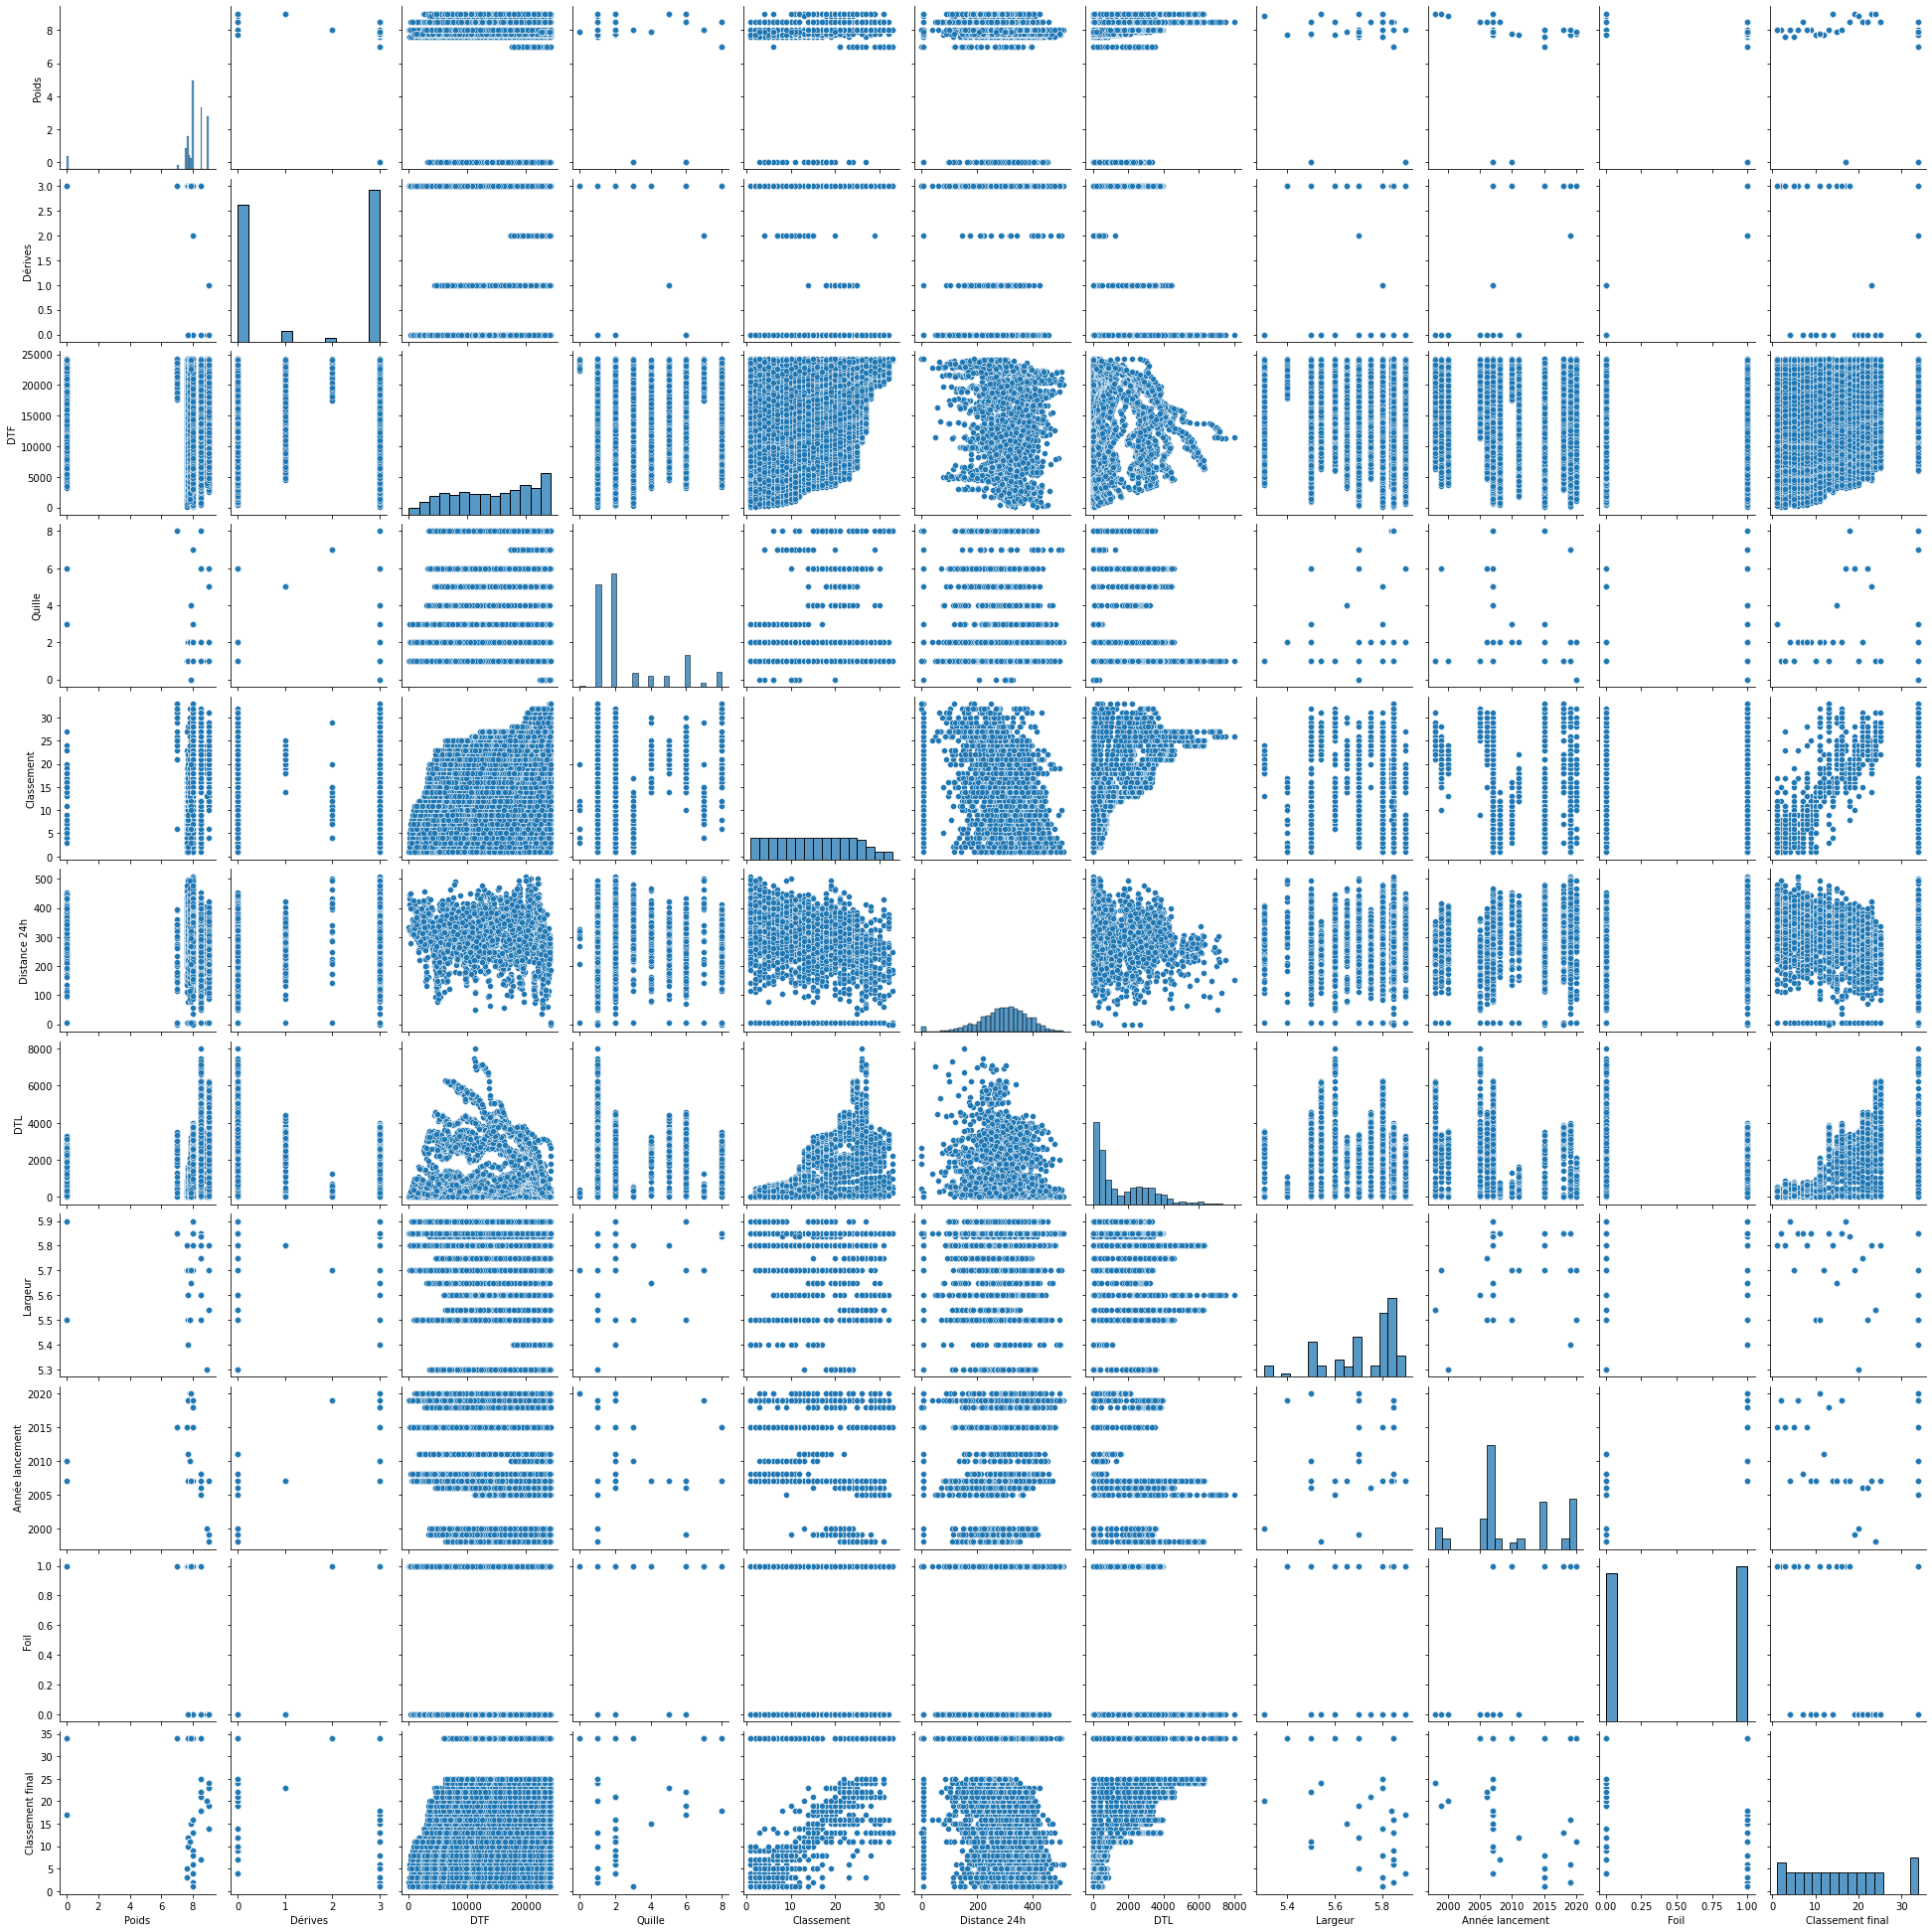

In [43]:
# pairplot sur 6 composantes sélectionnes aléatoirement
# Tracé du Scatterplot
df_sample = num_df.sample(n=10,axis='columns')
df_sample[nom_colonne_y] = Y
df_sample.head()

sns.pairplot(df_sample)


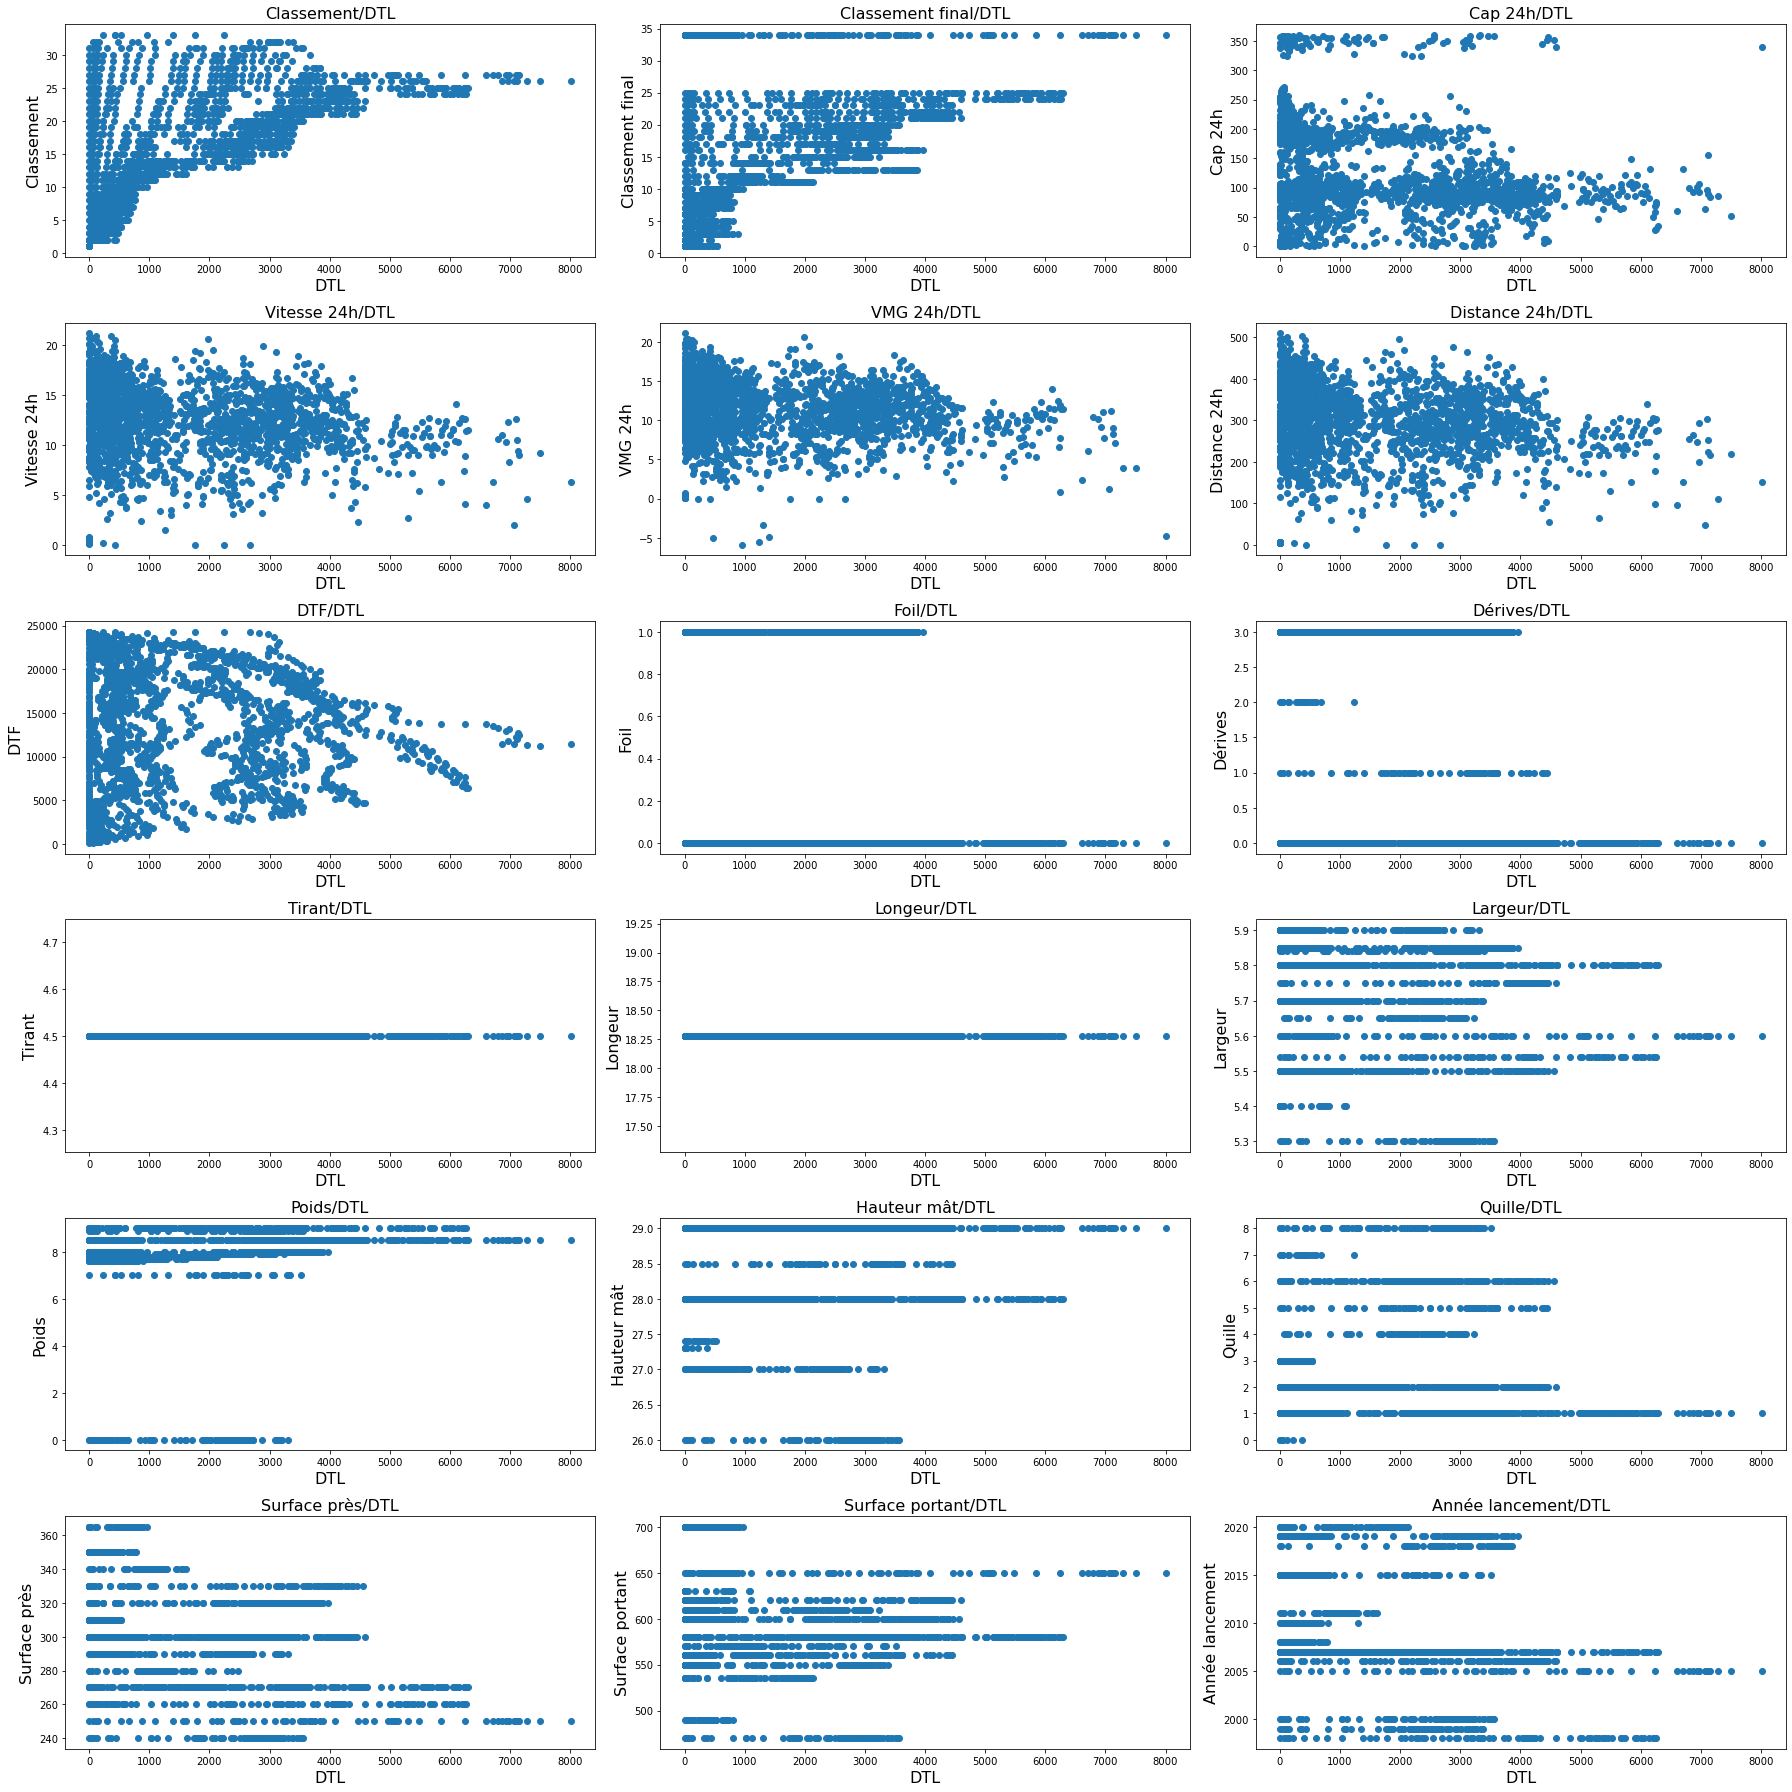

In [61]:
show_graphs(num_df, "DTL")

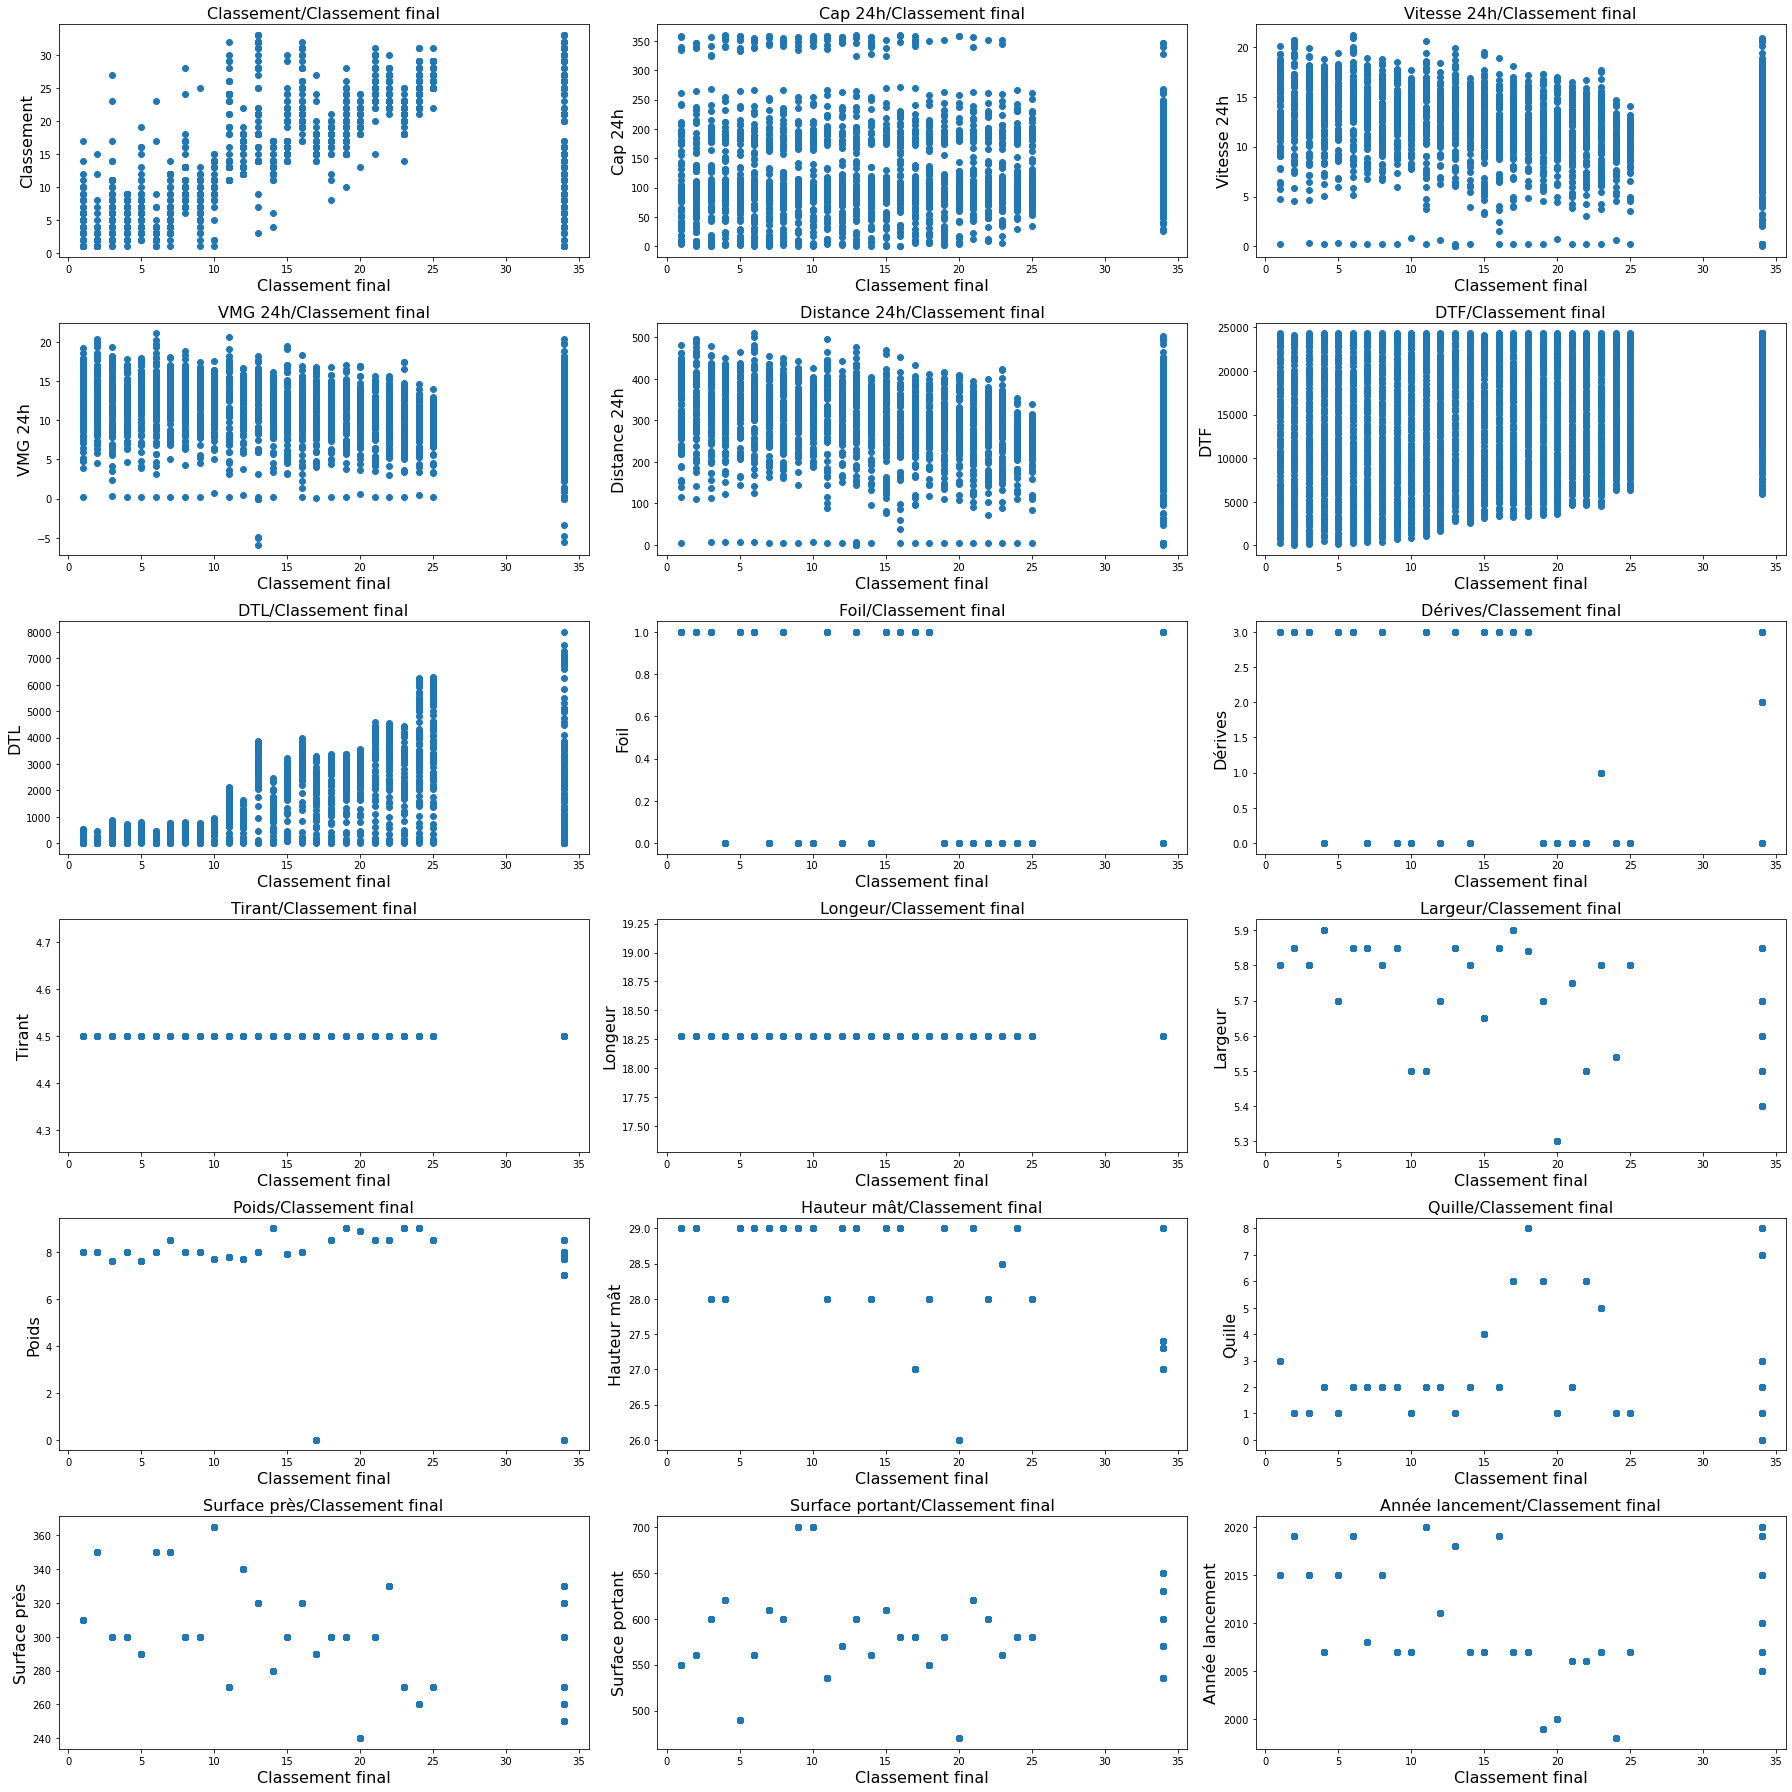

In [60]:
nom_colonne_y = "Classement final"

def show_graphs(num_df, nom_colonne_y):
    Y = num_df[nom_colonne_y]
    X_cols=[]
    X_cols = num_df.columns.to_list()
    # on enlève le nom de la colonne Y
    X_cols.remove(nom_colonne_y)

    X = num_df[X_cols]

    ncols=3
    nrows=int((len(num_df.columns)-1)/ncols)+ min(1, (len(num_df.columns)-1)%ncols)

    fig, axes = plt.subplots(ncols=ncols, nrows=nrows, figsize=(25 , 25))

    

    for i, ax ,col in zip(range(len(num_df.columns)-1), axes.flat, X_cols):
        ax.scatter(Y, X[col])
        ax.set_title(col + "/"+nom_colonne_y , fontsize = 16)
        ax.set_xlabel(nom_colonne_y, fontsize = 16)
        ax.set_ylabel(col, fontsize = 16)
    #     sns.distplot(data[i,0,0,0], hist=False, ax=ax)
    fig.tight_layout()
    plt.show()
    
show_graphs(num_df, nom_colonne_y)

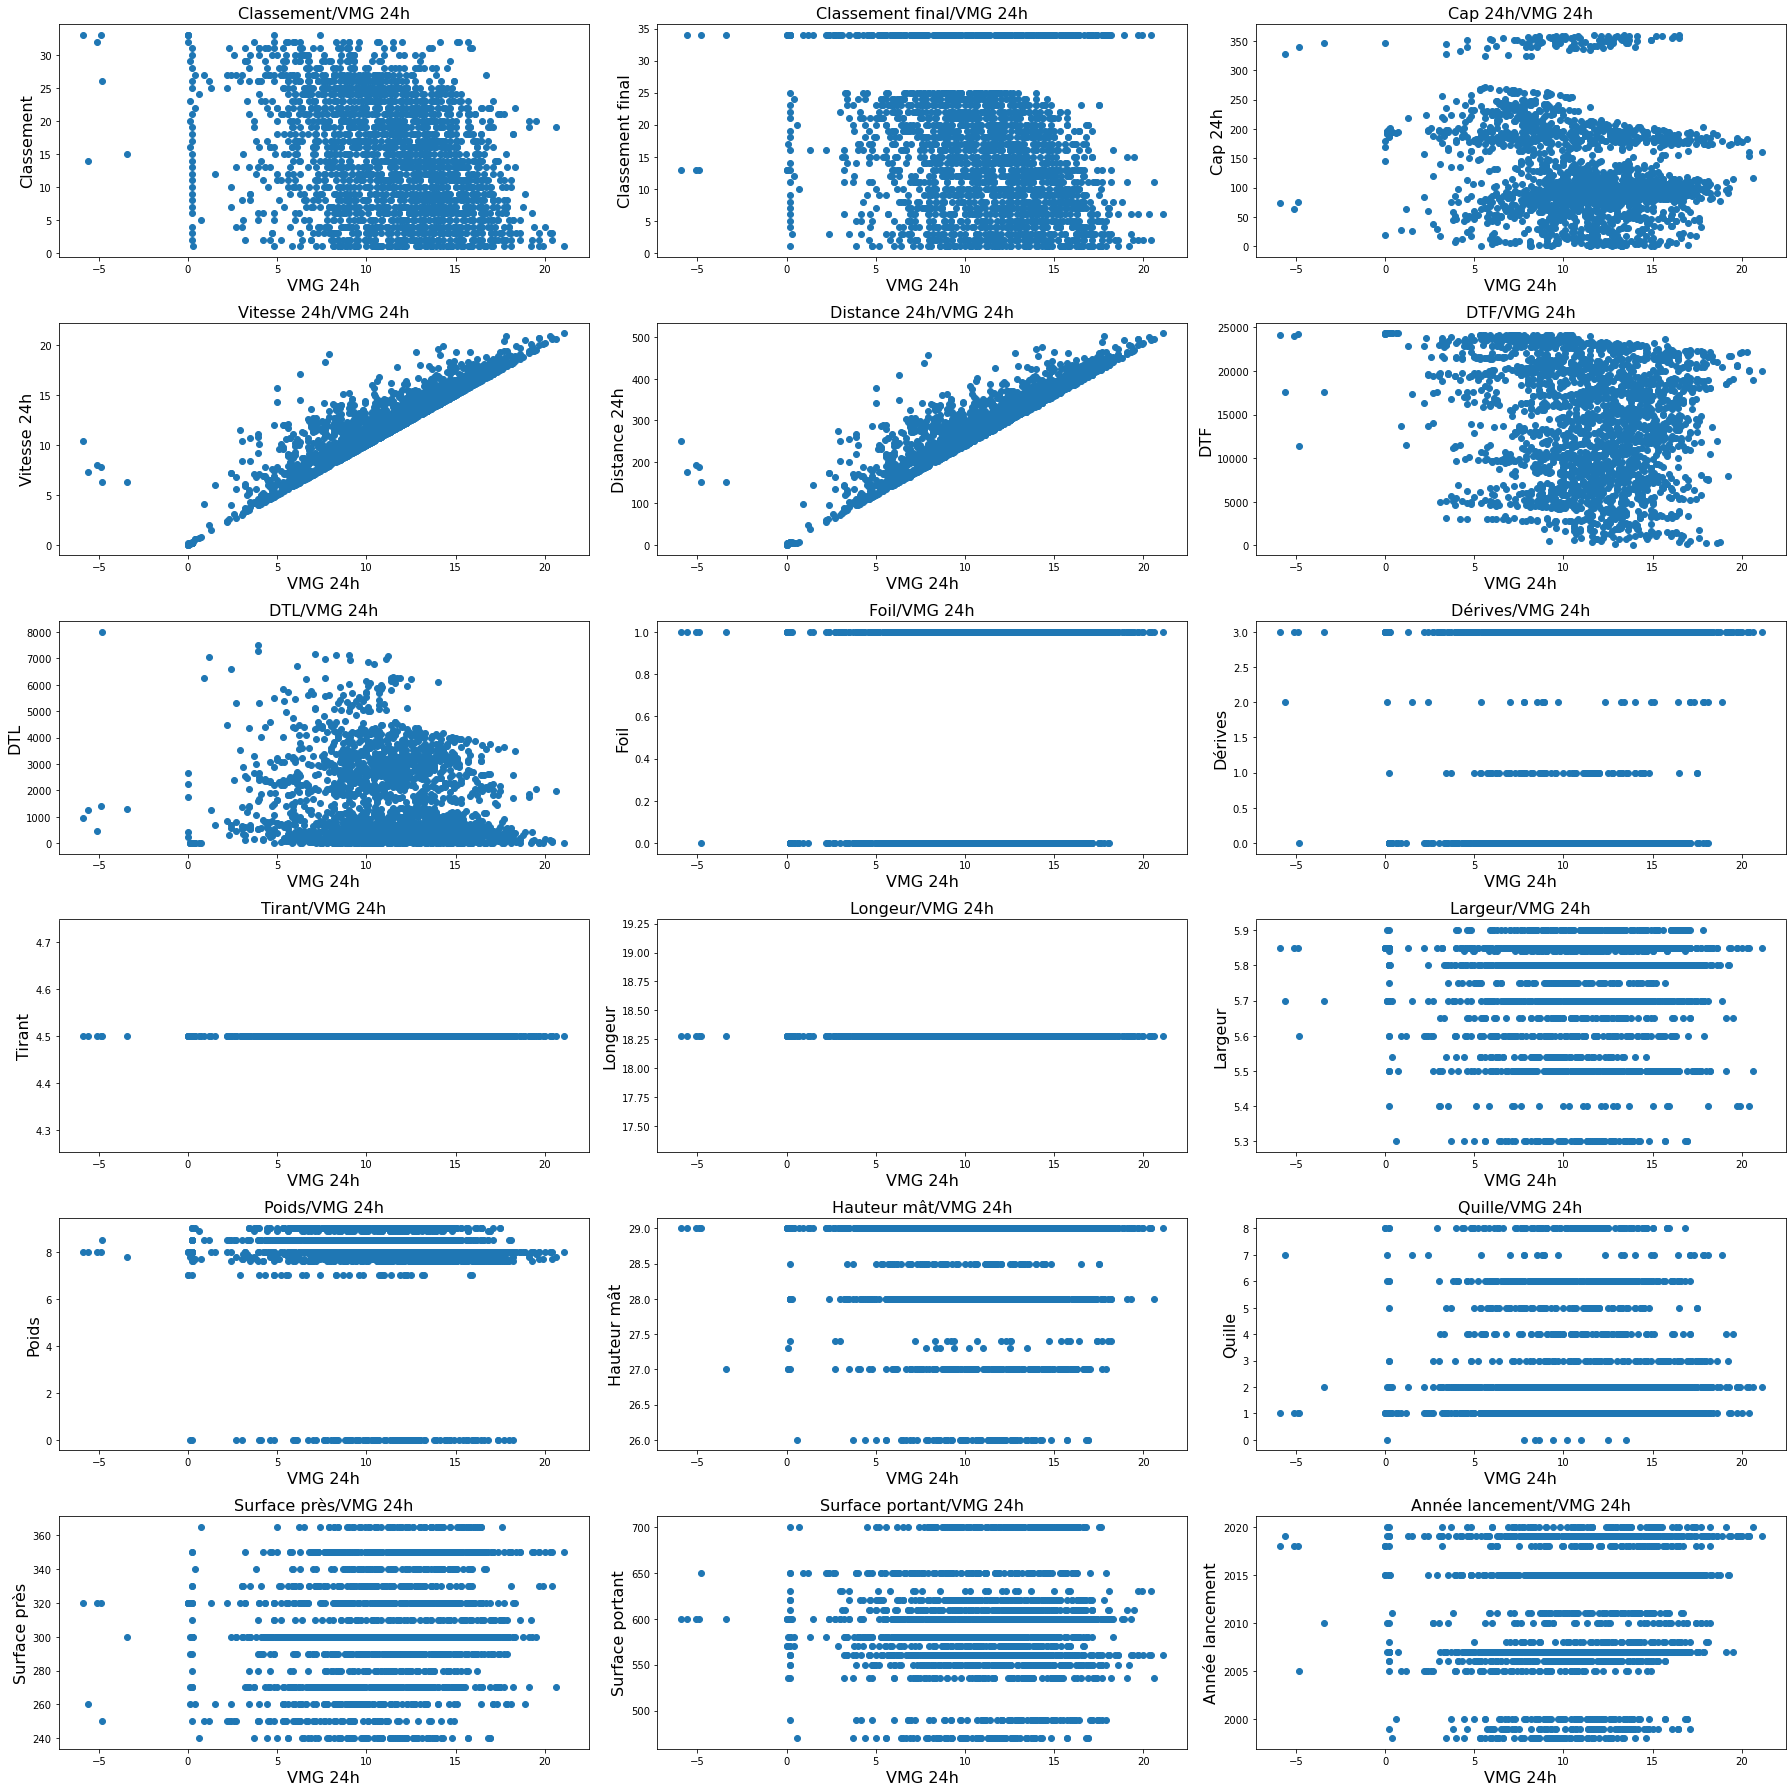

In [57]:
show_graphs(num_df, "VMG 24h")

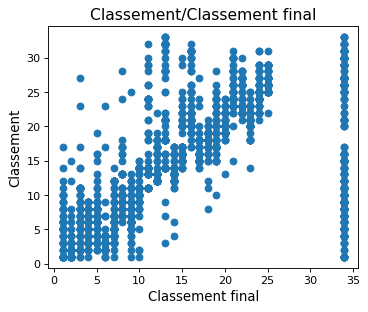

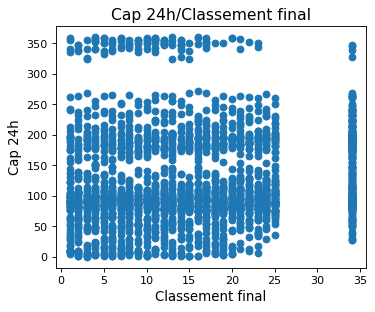

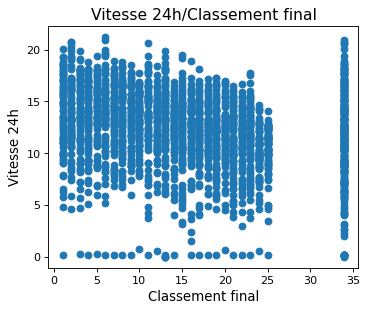

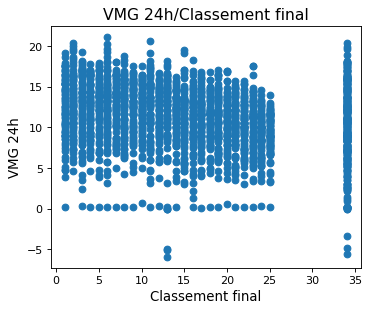

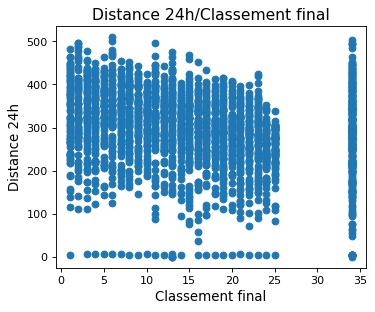

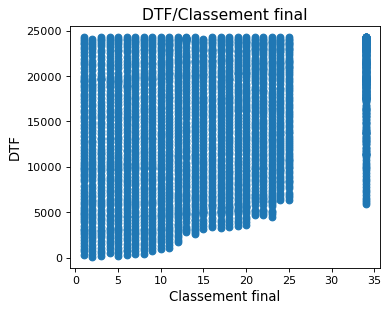

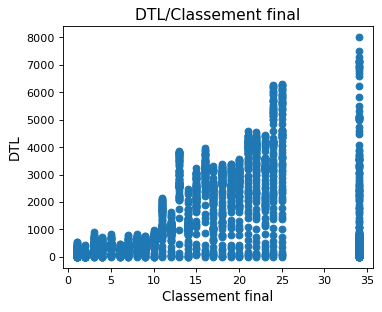

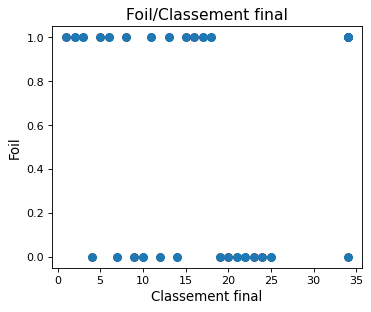

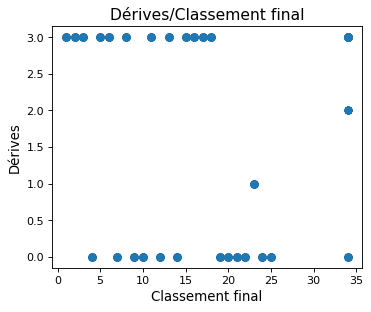

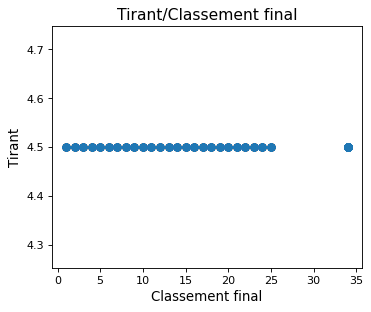

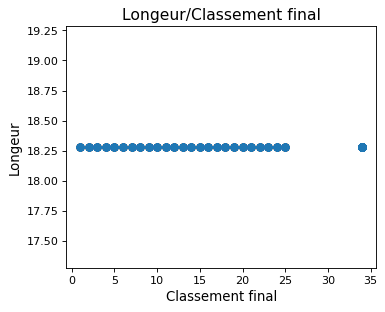

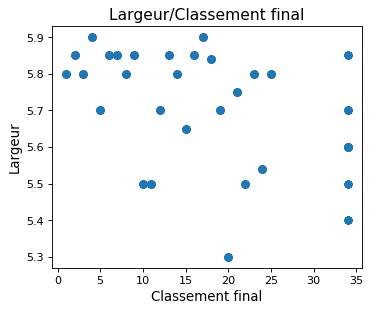

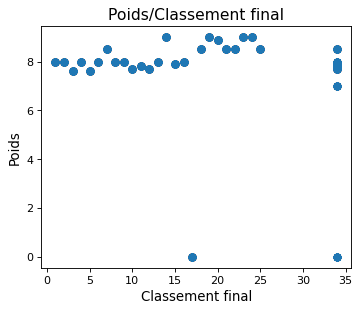

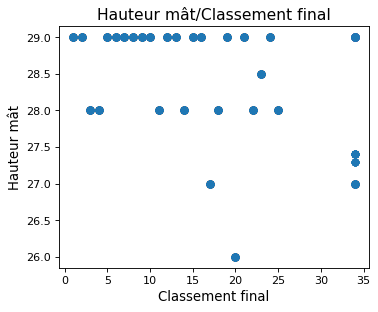

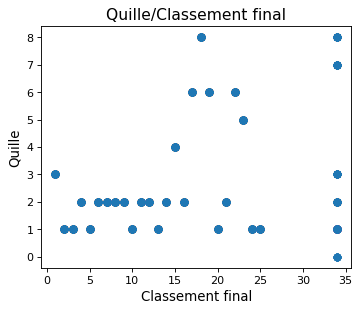

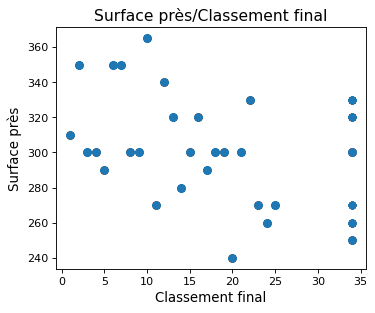

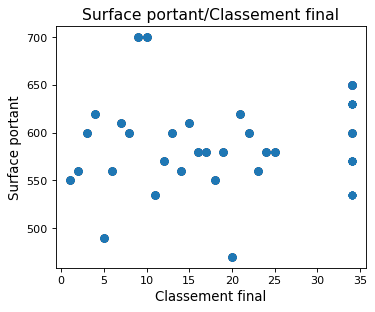

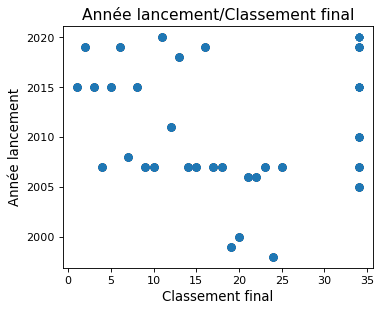

In [19]:
# for col in num_df.columns:
#     if col != 'Classement final':
#         plt.figure(figsize=(5, 4), dpi=80)

#         # On trace
#         plt.scatter(Y, X[col])
#         # On légende
#         plt.title(col + "/Classement final" , fontsize = 14)
#         plt.xlabel("Classement final", fontsize=12)
#         plt.ylabel(col, fontsize=12)


In [20]:

# import dateutil
stamp = dateparser.parse("20211012_080000")
# df['Stamp'] = stamp
stamp


In [21]:
##############################################################
## Fonction qui convertit les coordonnées en format décimal ##
##############################################################

def dms2dec(deg, mn, sec):
    return deg + mn / 60 + sec / 3600

In [22]:
# xlsxpath='results/vendeeglobe_20201110_080000.xlsx'
# x = pd.read_excel(xlsxpath, skiprows=[1, 2, 3], 
#                           header=1, 
#                           usecols=range(1,21), 
#                           skipfooter=4)
        
# # ajout colonne avec le timestamp du fichier d'où est extrait la data
# x['Fichier de resultats'] = xlsxpath[-20:-5]
# x = clean_data(x)
# x

In [23]:
# remove nan lines
# extract pour chaque bateau la vitesse / 24 en histogramme
# correlation vitesse distance
# 


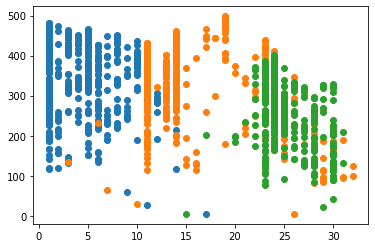

In [24]:
# 
fig, ax = plt.subplots(1,1)

for i in [1, 11, 21]:
    s = df.loc[df['Classement final']==i]
    X = s['Classement']
    Y = s['Distance 24h']
    x = np.linspace(0, len(s)/4, len(s))
    ax.scatter(X, Y)

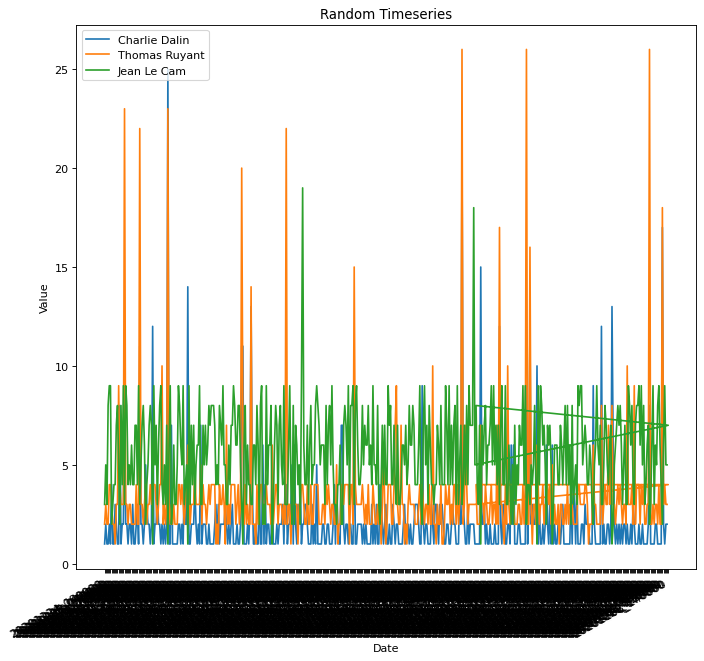

In [25]:
# MATPLOTLIB
fig, ax = plt.subplots(1, 1, figsize=(10, 10), dpi=80)
 
for k in df.Skipper.unique()[0:3]:
    tmp = df[df.Skipper == k]
    ax.plot(tmp['Fichier de resultats'], tmp['Classement'], label=k)
 
    ax.set(xlabel='Date', ylabel='Value', title='Random Timeseries')
 
    ax.legend(loc=2)
    
    fig.autofmt_xdate()

TypeError: Cannot perform 'rand_' with a dtyped [object] array and scalar of type [bool]

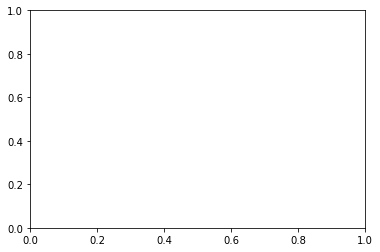

In [26]:
df['Fichier de resultats'].apply(lambda x: x.split('_')[1])=="080000"

# 
fig, ax = plt.subplots(1,1)
for i in [1, 20]:
    s = df.loc[df['Classement final']==i & 
    df['Fichier de resultats'].apply(lambda x: x.split('_')[1])=="080000"]
    pass
#     print(s2)
#     X = s2['Classement']
#     Y = s2['Distance 24h']
    
#     x = np.linspace(0, len(s)/4, len(s))
#     ax.plot(x, Y)

    

In [ ]:
# 
fig, ax = plt.subplots(1,1)
m=i%3
for i in [1, 20]:
    s = df.loc[df['Classement final']==i & df['Fichier de resultats'] == "080000"]
    X = s['Classement']
    Y = s['Distance 24h']
    
    xxbar = (X - X.mean())
    covX = xxbar@xxbar.T
    print(covX)
    covXY = xxbar@(Y - Y.mean())
    print(covXY)
    x = np.linspace(0, len(s)/4, len(s))
    ax.plot(x, Y)


In [ ]:
# ### https://cedric.cnam.fr/vertigo/Cours/ml/tpAcp.html ### #

import numpy as np
# Génération de données selon une loi normale tridimensionnelle
rndn3d = np.random.randn(500,3)

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Affichage du nuage de points
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(rndn3d[:,0], rndn3d[:,1], rndn3d[:,2])
plt.title("Données initiales")
plt.show()

# 
from sklearn.decomposition import PCA

pca = PCA(n_components=3)
pca.fit(rndn3d)

print("Pourcentage de variance expliquée : ")
print(pca.explained_variance_ratio_)
print("Composantes principales : ")
print(pca.components_)

#
s1 = np.array([[3,0,0],[0,1,0],[0,0,0.2]])  # matrice de déformation
r1 = np.array([[0.36,0.48,-0.8],[-0.8,0.6,0],[0.48,0.64,0.6]])  # matrice de rotation
rndef = rndn3d.dot(s1).dot(r1)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(rndef[:,0], rndef[:,1], rndef[:,2])
plt.title("Données déformées")
plt.show()


# 
pca = PCA(n_components=3)
pca.fit(rndef)

print("Pourcentage de variance expliquée : ")
print(pca.explained_variance_ratio_)
print("Composantes principales : ")
print(pca.components_)

In [ ]:
import numpy as np
# Génération de données selon une loi normale tridimensionnelle
x1 = df['Distance 24h'] 
x2 = df['Classement final'] 
x3 = df['Hauteur mât']
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Affichage du nuage de points
fig = plt.figure(figsize=(10, 10), dpi=80)
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x1, x2, x3)
plt.title("Données initiales")
plt.show()

In [ ]:
# séries temporelles
# évolution de la position du bateau dans le classement par rapport à l'ordre d'arrivée



In [ ]:
# évolution de la vitesse par tranche de latitude
# distance / vitesse pour vérifier corrélation
# vitesse / présence foil
# classement / présence foil
# cl et vit / foil
# 

In [ ]:

# Fixing random state for reproducibility
np.random.seed(19680801)

# some random data
x = np.random.randn(500)
y = np.random.randn(500)


def scatter_hist(x, y, ax, ax_histx, ax_histy):
    # no labels
    ax_histx.tick_params(axis="x", labelbottom=False)
    ax_histy.tick_params(axis="y", labelleft=False)

    # the scatter plot:
    ax.scatter(x, y)

    # now determine nice limits by hand:
    binwidth = 0.25
    xymax = max(np.max(np.abs(x)), np.max(np.abs(y)))
    lim = (int(xymax/binwidth) + 1) * binwidth

    bins = np.arange(-lim, lim + binwidth, binwidth)
    ax_histx.hist(x, bins=bins)
    ax_histy.hist(y, bins=bins, orientation='horizontal')
    
# definitions for the axes
left, width = 0.1, 0.65
bottom, height = 0.1, 0.65
spacing = 0.005


rect_scatter = [left, bottom, width, height]
rect_histx = [left, bottom + height + spacing, width, 0.2]
rect_histy = [left + width + spacing, bottom, 0.2, height]

# start with a square Figure
fig = plt.figure(figsize=(8, 8))

ax = fig.add_axes(rect_scatter)
ax_histx = fig.add_axes(rect_histx, sharex=ax)
ax_histy = fig.add_axes(rect_histy, sharey=ax)

# use the previously defined function
scatter_hist(x, y, ax, ax_histx, ax_histy)

plt.show()

* Rapprochement des données des voiliers avec celle des classements.
* Corrélation et régression linéaire entre le classement (rang) et la vitesse utile (VMG) des voiliers.
* Impact de la présence d'un foil sur le classement et la vitesse des voiliers.
* Visualisation de la distance parcourue par voilier.
* Cartes avec les routes d'un ou plusieurs voiliers.
* Analyses de séries temporelles.
* Application d'algorithmes statistiques ou de machine learning.
* etc.